In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
import datetime
from IPython.display import display_html
from itertools import chain,cycle
pd.options.display.float_format = '{:,.4f}'.format

# Data Processing

### Credit Data

In [2]:
"""
import data
"""
credit_data = pd.read_excel("PA Case Study Spreadsheet.xlsx", sheet_name="Main", skiprows=24)
credit_data.head(5)

,Credit,Facility,Modeled Par,Model Price,Spread,LIBOR Floor,1 year LIBOR,1 Year Income Rate,Maturity,Moody's CFR,Moody's Ratings Factor,S&P Industry,Recovery Rate
0,AAdvantage Loyalty IP Ltd,Term Loan,nan,0.9900,0.0475,0.0075,0.0019,0.0550,2028-03-10,Ba2,1350,Airlines,0.5000
1,"Acrisure, LLC",2020 Term Loan (First Lien),nan,0.9900,0.0350,0.0000,0.0019,0.0369,2027-02-15,B3,3490,Insurance,0.3000
2,"Acuris Finance US, Inc.",Initial Dollar Term Loan,nan,0.9975,0.0400,0.0050,0.0019,0.0450,2028-02-16,B2,2720,Interactive Media and Services,0.4000
3,ADMI Corp.,Amendment No. 4 Refinancing Term Loan,nan,1.0000,0.0325,0.0050,0.0019,0.0375,2027-12-23,B2,2720,Healthcare Providers and Services,0.3000
4,Advantage Sales & Marketing Inc.,Initial Term Loan (First Lien),nan,1.0086,0.0525,0.0075,0.0019,0.0600,2027-10-28,B2,2720,Media,0.4500


In [3]:
"""
ratings overview
"""
ratings = credit_data[["Moody's CFR", "Moody's Ratings Factor"]].drop_duplicates().sort_values(["Moody's Ratings Factor"])
B3_or_lower = ["B3", "Caa1"]
Caa_or_lower = ["Caa1"]
ratings

,Moody's CFR,Moody's Ratings Factor
160,Baa2,360
24,Ba1,940
0,Ba2,1350
33,Ba3,1766
15,B1,2220
2,B2,2720
1,B3,3490
16,Caa1,4770


In [4]:
"""
industry overview: 
1. industry names
2. the number of credits in each industry
"""
df_credit_industry = credit_data[["Credit","S&P Industry"]].groupby(["S&P Industry"]).count()
industry_list = df_credit_industry.index.to_list() #50 industries
df_credit_industry

,Credit
S&P Industry,
Aerospace and Defense,3
Air Freight and Logistics,1
Airlines,1
Auto Components,9
Biotechnology,2
Building Products,4
Capital Markets,3
Chemicals,4
Commercial Services and Supplies,10


In [5]:
"""
distribution of numerical features
"""
credit_data.describe()

,Modeled Par,Model Price,Spread,LIBOR Floor,1 year LIBOR,1 Year Income Rate,Moody's Ratings Factor,Recovery Rate
count,0.0000,209.0000,209.0000,209.0000,209.0000,209.0000,209.0000,209.0000
mean,nan,1.0016,0.0358,0.0049,0.0019,0.0414,"2,669.9139",0.4052
std,nan,0.0057,0.0106,0.0042,0.0000,0.0122,767.3667,0.1247
min,nan,0.9800,0.0000,0.0000,0.0019,0.0019,360.0000,0.0200
25%,nan,0.9975,0.0275,0.0000,0.0019,0.0344,"2,220.0000",0.3000
50%,nan,1.0015,0.0350,0.0050,0.0019,0.0425,"2,720.0000",0.4000
75%,nan,1.0053,0.0425,0.0075,0.0019,0.0475,"3,490.0000",0.5000
max,nan,1.0156,0.0850,0.0125,0.0019,0.0869,"4,770.0000",0.7000


### Constraint Data

In [6]:
constraint_data = pd.read_excel("PA Case Study Spreadsheet.xlsx", sheet_name="Portfolio Constraints")
low_risk_constraints = constraint_data[["Constraint","Low Risk"]]
high_risk_constraints = constraint_data[["Constraint","High Risk"]]
constraint_data

,Constraint,Low Risk,High Risk
0,Minimum Weighted Average Income Rate,0.0325,0.0435
1,Maximum Weight per Credit,0.0150,0.0250
2,Maximum Weighted Average Price,1.0000,0.9970
3,Maximum Weight Per Industry,0.1000,0.1500
4,Maximum % in B3 or lower,0.1500,0.4000
5,Maximum % in Caa or lower,0.0000,0.0200
6,Minimum S&P WARR,0.4300,0.3900


### Default Rate by Rating Data
Note: Seminole Tribe of Florida - Baa2 - 360

In [7]:
default_rate_data = pd.read_excel("PA Case Study Spreadsheet.xlsx", sheet_name="Default Rate by Rating")
sensi_bps_col_name = default_rate_data.columns.tolist()[-1]
default_rate_data["PDSensi"] = default_rate_data[sensi_bps_col_name].apply(lambda r: float(r)/100.0)
default_rate_data

,Rating,WARF,Base Default Rate,Change in Default Rate per 100 bps Change in B2 Default Rate (bps),PDSensi
0,Baa2,360,0.0036,5,0.0500
1,Baa3,610,0.0061,10,0.1000
2,Ba1,940,0.0094,20,0.2000
3,Ba2,1350,0.0135,35,0.3500
4,Ba3,1766,0.0177,50,0.5000
5,B1,2220,0.0222,70,0.7000
6,B2,2720,0.0272,100,1.0000
7,B3,3490,0.0349,150,1.5000
8,Caa1,4770,0.0477,250,2.5000


# Portfolio Optimization

In [8]:
class CreditPortfolio(object):
    number_of_portfolio = 0
    
    def __init__(self, name, credit_data, constraint_data, default_rate_data, total_cost=500000000):
        self.name = name
        self.credit_data = credit_data
        self.constraint_data = constraint_data
        self.default_rate_data = default_rate_data
        self.total_cost = total_cost
        self.weights = None
        self.sector_list = []
        self.recovery_upon_default = 0.6
        CreditPortfolio.number_of_portfolio += 1
    
    def encode_industry(self, industry_col_name):
        """
        Function Usage: get industry matrix called "Ind"
        Input: name of the industry classification column
        Output: a industry matrix which is n_industry*n_credit; row for industry, column for credit
        """
        Ind = pd.get_dummies(self.credit_data[industry_col_name])
        self.sector_list = Ind.columns.tolist()
        Ind = np.matrix(Ind) #209*50 for sample data
        return Ind
    
    def get_identity_matrix(self, n):
        """
        Function Usage: get n*n identity matrix called "Id"
        Input: size of the matrix 
        Output: n*n identity matrix
        """
        Id = np.matrix(np.eye(n))
        return Id
    
    def get_eye_vec(self, n):
        """
        Function Usage: get n eye vector(all ones) formatted as n*1 matrix
        Input: size of the eye vector
        Output: eye vector formatted as n*1 matrix
        """
        eye = np.matrix(np.ones(n)).T
        return eye
    
    def get_rating_vec(self, rating_col_name, arr_ratings):

        """
        Function Usage: generate character vector given the array of ratings included
        Input: name of the rating column, array of the ratings included
        Output: rating character vector formatted as n_credit*1 matrix
        """
        rating_vec = self.credit_data[rating_col_name].apply(lambda r: float(r in arr_ratings)).values
        rating_vec = np.matrix(rating_vec).T #209*1 for sample data
        return rating_vec
    
    def get_n_industry(self):
        n_industry = len(self.credit_data["S&P Industry"].drop_duplicates().tolist())
        return n_industry
    
    def portfolio_optimization(self):
        """
        Set up portfolio optimization problem and get weights/costs through optimizer
        """
        #number of credits
        n_credit = self.credit_data.shape[0]
        
        #number of industries
        n_industry = self.get_n_industry()
        
        #constraints
        min_WAIR = self.constraint_data.iloc[0,1]
        max_per_credit = self.constraint_data.iloc[1,1]
        max_WAP = self.constraint_data.iloc[2,1]
        max_per_industry = self.constraint_data.iloc[3,1]
        max_B3_or_lower = self.constraint_data.iloc[4,1]
        max_Caa_or_lower = self.constraint_data.iloc[5,1]
        min_WARR = self.constraint_data.iloc[5,1]
        
        ######################################################################
        """
        Objective Function
        """
        #RF: Ratings Factor
        RF = np.matrix(self.credit_data["Moody's Ratings Factor"].values).T #209*1
        def WARF(w):
            #w: weight vector with shape [209,]
            #RF: rating factor vector with shape [209,1]
            portfolio_RF = (w.dot(RF))[0,0]
            return portfolio_RF

        ######################################################################
        """
        Constraints
        """
        #FI: fully invested
        FI = np.matrix(np.ones(n_credit)).T #209*1
        FI_lb = np.matrix(1.0) #lower bound 1*1
        FI_ub = np.matrix(1.0) #higher bound 1*1
        
        #IR: Income Rate
        IR = np.matrix(self.credit_data["1 Year Income Rate"].values).T #209*1
        IR_lb = np.matrix(min_WAIR) #lower bound 1*1
        IR_hb = np.matrix(np.inf) #higher bound 1*1

        #Id: Individual weight
        Id = np.matrix(np.eye(n_credit)) #209*209
        Id_lb = np.matrix(np.ones(n_credit)).T * (0.0) #lower bound 209*1 [Long-only]
        Id_hb = np.matrix(np.ones(n_credit)).T * max_per_credit #higher bound 209*1

        #P: Price
        modeled_price = self.credit_data["Model Price"].values #vector [209,]
        P = np.matrix(modeled_price).T #209*1
        P_lb = np.matrix(-np.inf) #lower bound 1*1
        P_hb = np.matrix(max_WAP) #higher bound 1*1

        #Ind: Industry Matrix
        Ind = self.encode_industry("S&P Industry") #209*50
        Ind_lb = np.matrix(np.ones(n_industry)).T * (-np.inf) #lower bound 50*1
        Ind_hb = np.matrix(np.ones(n_industry)).T * max_per_industry #higher bound 50*1

        #B3 or lower: 209*1
        B3 = self.credit_data["Moody's Ratings Factor"].apply(lambda r: float(r in B3_or_lower)).values 
        B3 = np.matrix(B3).T
        B3_lb = np.matrix(-np.inf) #lower bound 1*1
        B3_hb = np.matrix(max_B3_or_lower) #higher bound 1*1

        #Caa or lower: #209*1
        Caa = self.credit_data["Moody's Ratings Factor"].apply(lambda r: float(r in Caa_or_lower)).values 
        Caa = np.matrix(Caa).T
        Caa_lb = np.matrix(-np.inf) #lower bound 1*1
        Caa_hb = np.matrix(max_Caa_or_lower) #higher bound 1*1

        #RR: Recovery Rate
        RR = np.matrix(self.credit_data["Recovery Rate"].values).T #209*1
        RR_lb = np.matrix(min_WARR) #lower bound 1*1
        RR_hb = np.matrix(np.inf) #higher bound 1*1
        
        # stack constraint paramters together
        M = np.hstack((FI, IR, Id, P, Ind, B3, Caa, RR)) #209*265
        LB = np.vstack((FI_lb, IR_lb, Id_lb, P_lb, Ind_lb, B3_lb, Caa_lb, RR_lb)) #265*1
        UB = np.vstack((FI_ub, IR_hb, Id_hb, P_hb, Ind_hb, B3_hb, Caa_hb, RR_hb)) #265*1
        
        #optimization intial weights
        w0 = np.ones(n_credit) * (1.0/n_credit)
        
        #constraints
        linear_constraints = LinearConstraint( M.T.tolist(), LB.T.tolist()[0], UB.T.tolist()[0] ) 

        #optimization
        res = minimize( WARF, w0, 
                        method='trust-constr',
                        constraints=[linear_constraints],
                        options={'verbose': 1, 
                                 'initial_constr_penalty': 10000000000,
                                 #'xtol': 1e-8, 
                                 #'gtol': 1e-8,
                                 #'maxiter': 100000,
                                }
                      )
        self.weights = res.x
        portfolio_cost = self.weights * self.total_cost
        
        return portfolio_cost
        
    def run(self):
        """
        Run Portfolio Optimization, Get Final Costs and Modeled Par, and Put into Pandas DataFrame
        """
        self.credit_data["Cost"] = self.portfolio_optimization()
        self.credit_data["Modeled Par"] = self.credit_data.apply(lambda r: r["Cost"]/r["Model Price"], axis=1)
        self.credit_data["Weight"] = self.credit_data.apply(lambda r: r["Cost"]/self.total_cost, axis=1)
        
    @staticmethod
    def format_percent(number):
        return str(round(number*100,2))+"%"
    
    @staticmethod
    def display_side_by_side(*args,titles=cycle([''])):
        html_str=''
        for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
            html_str+='<th style="text-align:center"><td style="vertical-align:top">'
            html_str+=f'<h2>{title}</h2>'
            html_str+=df.to_html().replace('table','table style="display:inline"')
            html_str+='</td></th>'
        display_html(html_str,raw=True)
    
    def portfolio_metrics(self):
        """
        Generate Below Portfolio Metrics:
        Weighted Average Spread
        Weighted Average Income Rate
        Weighted Average Maturity
        Weighted Average Ratings Factor (WARF)
        Weighted Average Recovery Rate (WARR)
        """
        WAS = np.sum(self.credit_data["Weight"]*self.credit_data["Spread"])
        WAIR = np.sum(self.credit_data["Weight"]*self.credit_data["1 Year Income Rate"])
        timestamp_avg = np.sum(self.credit_data["Weight"].values*self.credit_data["Maturity"].apply(lambda r: r.timestamp()))
        WAM = datetime.datetime.fromtimestamp(timestamp_avg).strftime("%Y-%m-%d %H:%M:%S")
        WARF = np.sum(self.credit_data["Weight"]*self.credit_data["Moody's Ratings Factor"])
        WARR = np.sum(self.credit_data["Weight"]*self.credit_data["Recovery Rate"])
        WAP = np.sum(self.credit_data["Weight"]*self.credit_data["Model Price"])
        
        df_metrics = pd.DataFrame( [["Weighted Average Spread", CreditPortfolio.format_percent(WAS)],
                                    ["Weighted Average Income Rate", CreditPortfolio.format_percent(WAIR)],
                                    ["Weighted Average Maturity", WAM],
                                    ["Weighted Average Ratings Factor", str(round(WARF,1))],
                                    ["Weighted Average Recovery Rate", CreditPortfolio.format_percent(WARR)],
                                    ["Weighted Average Price", CreditPortfolio.format_percent(WAP)]
                                   ], columns = ["Metric", "Value"])
        return df_metrics
        
    def top_5_credits_by_size(self):
        df_temp = self.credit_data[["Credit","Modeled Par"]].sort_values(["Modeled Par"], ascending=False).head(5)
        #df_temp["Modeled Par"] = df_temp["Modeled Par"].apply(lambda r: "${:,.0f}".format(r))
        #df_temp = df_temp.style.format({"Modeled Par":"{:.0f}"})
        return df_temp
        
    def top_5_industries_by_size(self):
        df_temp = self.credit_data[["S&P Industry", "Modeled Par"]].groupby(["S&P Industry"]).sum()
        df_temp = df_temp.sort_values(["Modeled Par"],ascending=False).head(5)
        #df_temp["Modeled Par"] = df_temp["Modeled Par"].apply(lambda r: "${:,.0f}".format(r))
        #df_temp = df_temp.style.format({"Modeled Par":"{:.0f}"})
        return df_temp
    
    def ratings_distribution(self):
        #rating-level distribution
        df_rating_dist = self.credit_data[["Moody's CFR","Weight"]].groupby(["Moody's CFR"]).sum()
        
        #merge in Ratings Factor data to sort
        RF = self.default_rate_data[["Rating","WARF"]]
        df_rating_dist = df_rating_dist.merge(RF, left_index=True, right_on="Rating",suffixes=("", ""))
        df_rating_dist = df_rating_dist.sort_values("WARF")
        return df_rating_dist

        
    def sector_distribution(self):
        df_sec_w = np.matrix(self.weights)*self.encode_industry("S&P Industry")
        sector_weights = df_sec_w.tolist()[0]
        df_sec_w = pd.DataFrame(sector_weights, columns=["Sector Weight"],
                                index=self.sector_list).sort_values("Sector Weight",ascending=False)
        #print( df_sec_w.style.format({"Sector Weight":"{:.4f}"}) )
        return df_sec_w
    
    def get_category_base_default_rate(self, category_name):
        ratings = self.default_rate_data.Rating.tolist()
        base_default_rates = self.default_rate_data["Base Default Rate"].tolist()
        base_default_rate_dct = {x:y for x,y in zip(ratings,base_default_rates)}
        return base_default_rate_dct[category_name]
    
    def default_scenario_analysis(self):
        temp2 = self.credit_data
        temp1 = self.default_rate_data
        self.credit_data = self.credit_data.merge(self.default_rate_data[["Rating","Base Default Rate","PDSensi"]], 
                                                  left_on="Moody's CFR", right_on="Rating", suffixes=("", ""))
        #Income = Par * Income Rate
        income = np.sum(self.credit_data["Modeled Par"]*self.credit_data["1 Year Income Rate"])
        
        #Base Default Senario
        base_loss = np.sum(self.credit_data["Base Default Rate"]*self.credit_data["Cost"]*(1-self.recovery_upon_default) )
        loss_sensi = np.sum(self.credit_data["PDSensi"]*self.credit_data["Cost"]*(1-self.recovery_upon_default))
        base_ret = (income - base_loss)/self.total_cost
        
        #Other Default Scenario
        B2_base_default_rate = self.get_category_base_default_rate("B2")
        B2_default_rate = np.linspace(B2_base_default_rate, 0.2+B2_base_default_rate, 51)
        ptf_ret = (income-base_loss-loss_sensi*(B2_default_rate-B2_base_default_rate))/self.total_cost
        
        ret_sensi = loss_sensi/self.total_cost
        return base_ret, ret_sensi, B2_default_rate, ptf_ret

# Low Risk Portfolio v.s. High Risk Portfolio

In [9]:
#Low Risk Portfolio
ptf_low_risk = CreditPortfolio("Low Risk Portfolio", 
                               credit_data.copy(deep=True),
                               low_risk_constraints.copy(deep=True),
                               default_rate_data.copy(deep=True), 
                               total_cost=500000000)
ptf_low_risk.run()
#ptf_low_risk.credit_data.to_excel("Low Risk Portfolio.xlsx", index=False)

#High Risk Portfolio
ptf_high_risk = CreditPortfolio("High Risk Portfolio",
                                credit_data.copy(deep=True),
                                high_risk_constraints.copy(deep=True), 
                                default_rate_data.copy(deep=True), 
                                total_cost=500000000)
ptf_high_risk.run()
#ptf_high_risk.credit_data.to_excel("High Risk Portfolio.xlsx", index=False)

/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/_hessian_update_strategy.py:187: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  'approximations.', UserWarning)


`gtol` termination condition is satisfied.
Number of iterations: 242, function evaluations: 48720, CG iterations: 311, optimality: 6.46e-11, constraint violation: 8.63e-09, execution time:  5.8 s.
`gtol` termination condition is satisfied.
Number of iterations: 745, function evaluations: 155190, CG iterations: 857, optimality: 3.22e-10, constraint violation: 0.00e+00, execution time: 1.6e+01 s.


# Portfolio Metric

In [10]:
metrics_low, metrics_high = ptf_low_risk.portfolio_metrics(), ptf_high_risk.portfolio_metrics()
CreditPortfolio.display_side_by_side(metrics_low, metrics_high, titles=['Low Risk Portfolio','High Risk Portfolio'])

,Metric,Value
0,Weighted Average Spread,2.86%
1,Weighted Average Income Rate,3.25%
2,Weighted Average Maturity,2026-12-06 03:29:42
3,Weighted Average Ratings Factor,1785.9
4,Weighted Average Recovery Rate,46.96%
5,Weighted Average Price,100.0%
,Metric,Value
0,Weighted Average Spread,3.8%
1,Weighted Average Income Rate,4.35%
2,Weighted Average Maturity,2027-03-12 15:25:44


# Top 5 Credits by Size

In [11]:
top_credits_low, top_credits_high = ptf_low_risk.top_5_credits_by_size(), ptf_high_risk.top_5_credits_by_size()
CreditPortfolio.display_side_by_side(top_credits_low, top_credits_high, titles=['Low Risk Portfolio','High Risk Portfolio'])

,Credit,Modeled Par
0,AAdvantage Loyalty IP Ltd,"7,575,761.7480"
25,"Asurion, LLC","7,575,761.6755"
58,"Enviva Holdings, LP","7,575,761.6385"
103,"LogMeIn, Inc.","7,556,678.5999"
64,Froneri International Limited,"7,552,874.0864"
,Credit,Modeled Par
58,"Enviva Holdings, LP","12,626,261.4959"
0,AAdvantage Loyalty IP Ltd,"12,626,261.4257"
130,PetSmart LLC,"12,626,258.2485"
25,"Asurion, LLC","12,626,257.4341"


# Top 5 Industries by Size

In [12]:
top_ind_low, top_ind_high = ptf_low_risk.top_5_industries_by_size(), ptf_high_risk.top_5_industries_by_size()
CreditPortfolio.display_side_by_side(top_ind_low, top_ind_high, titles=['Low Risk Portfolio','High Risk Portfolio'])

,Modeled Par
S&P Industry,
Commercial Services and Supplies,"49,859,621.3752"
Specialty Retail,"25,322,643.1502"
Food Products,"22,560,209.3161"
Insurance,"22,557,228.4420"
Capital Markets,"22,483,031.9550"
,Modeled Par
S&P Industry,
Commercial Services and Supplies,"50,071,573.1714"
Specialty Retail,"25,189,162.0752"


# Sector Weights Distribution and Skewness
1. Both the High Risk Portfolio and the Low Risk Portfolio are positively skewed.
2. High Risk Portfolio has less significant skewness than the Low Risk Portfolio.

In [13]:
low_risk_sec_weight = ptf_low_risk.sector_distribution()
high_risk_sec_weight = ptf_high_risk.sector_distribution()
sector_weights = pd.merge(high_risk_sec_weight, low_risk_sec_weight,left_index=True, right_index=True,
                 suffixes=("_high", "_low"))
sector_weights.skew()

Sector Weight_high   1.1647
Sector Weight_low    1.6037
dtype: float64

Text(0, 0.5, 'Count')

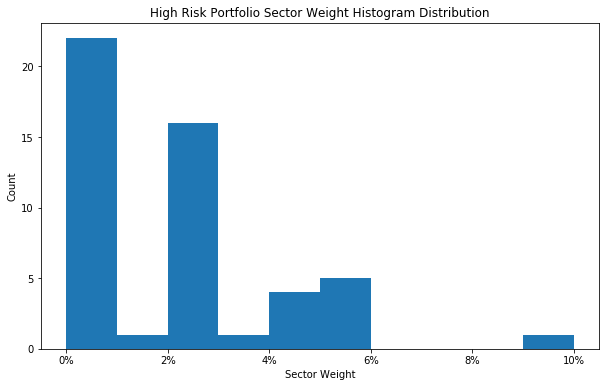

In [14]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(sector_weights["Sector Weight_high"].tolist())
vals = ax.get_xticks()
ax.set_xticklabels(['%1.0f%%' %(i*100) for i in vals]) #set y ticker as percentile
plt.title("High Risk Portfolio Sector Weight Histogram Distribution")
plt.xlabel("Sector Weight")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

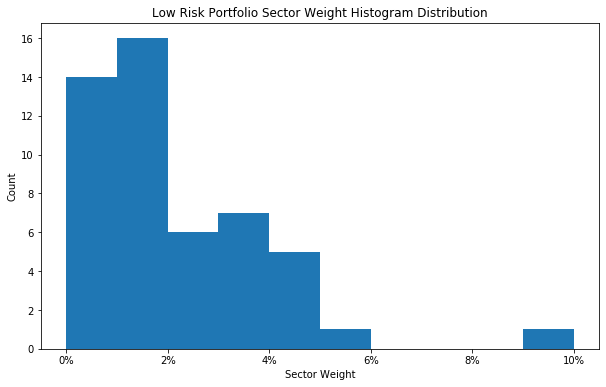

In [15]:
f, ax = plt.subplots(1, 1, figsize=(10,6))
ax.hist(sector_weights["Sector Weight_low"].tolist())
vals = ax.get_xticks()
ax.set_xticklabels(['%1.0f%%' %(i*100) for i in vals]) #set y ticker as percentile
plt.title("Low Risk Portfolio Sector Weight Histogram Distribution")
plt.xlabel("Sector Weight")
plt.ylabel("Count")

In [16]:
sector_weights["diff"] = sector_weights.apply(
    lambda r: "{:.2f}%".format((r["Sector Weight_high"]-r["Sector Weight_low"])*100), axis=1)
sector_weights["Sector Weight_high"] = sector_weights["Sector Weight_high"].apply(lambda r: "{:.2f}%".format(r*100))
sector_weights["Sector Weight_low"] = sector_weights["Sector Weight_low"].apply(lambda r: "{:.2f}%".format(r*100))
sector_weights

,Sector Weight_high,Sector Weight_low,diff
Commercial Services and Supplies,10.00%,10.00%,-0.00%
Diversified Financial Services,5.00%,3.00%,2.00%
Specialty Retail,5.00%,5.06%,-0.06%
Software,5.00%,3.00%,2.00%
Capital Markets,5.00%,4.50%,0.50%
Building Products,5.00%,3.00%,2.00%
Chemicals,5.00%,3.00%,2.00%
Interactive Media and Services,5.00%,1.50%,3.50%
Trading Companies and Distributors,5.00%,2.89%,2.11%
Diversified Telecommunication Services,5.00%,4.50%,0.50%


# Rating Category Distribution

In [17]:
df_rating_dist_low = ptf_low_risk.ratings_distribution()
df_rating_dist_high = ptf_high_risk.ratings_distribution()
low_weights = df_rating_dist_low.Weight.tolist()
high_weights = df_rating_dist_high.Weight.tolist()

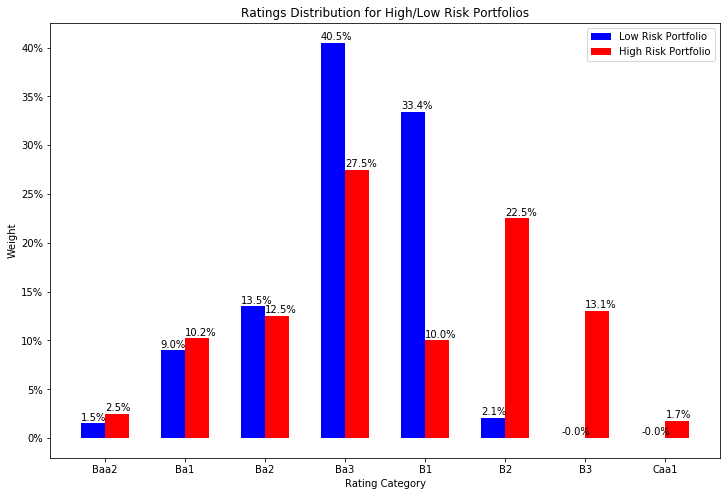

In [18]:
#plot
width = 0.3
ind = np.arange(len(df_rating_dist_low))
f, ax = plt.subplots(1, 1, figsize=(12,8))

ax.bar(ind, low_weights, width, color='blue', label='Low Risk Portfolio')
ax.bar(ind + width, high_weights, width, color='red', label='High Risk Portfolio')

plt.xlabel('Rating Category')
plt.ylabel('Weight')
plt.title("Ratings Distribution for High/Low Risk Portfolios")

plt.xticks(ind + width / 2, df_rating_dist_low.Rating.tolist())
vals = ax.get_yticks()
ax.set_yticklabels(['%1.0f%%' %(i*100) for i in vals]) #set y ticker as percentile

for p in ax.patches:#show values
    ax.annotate(str( round(p.get_height()*100, 1) )+"%", (p.get_x(), p.get_height() +0.003))
    
plt.legend(loc='best')
plt.savefig("Rating Distribution.jpg")
plt.show()

# Scenario Analysis

In [19]:
low_base_ret, low_ret_sensi, low_B2_default_rate, low_ptf_ret,  = ptf_low_risk.default_scenario_analysis()
high_base_ret, high_ret_sensi, high_B2_default_rate, high_ptf_ret = ptf_high_risk.default_scenario_analysis()

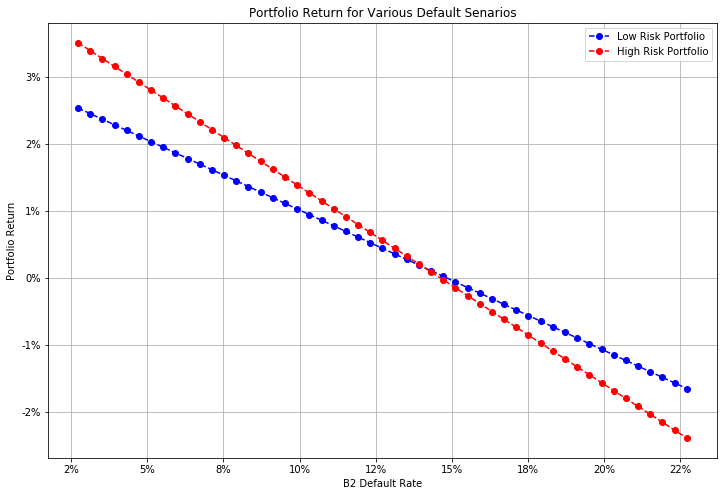

In [20]:
f, ax = plt.subplots(1, 1, figsize=(12,8))
ax.plot(low_B2_default_rate, low_ptf_ret, label="Low Risk Portfolio", 
        linestyle='--', marker='o', color='b')
ax.plot(high_B2_default_rate, high_ptf_ret, label="High Risk Portfolio", 
        linestyle='--', marker='o', color='r')
vals = ax.get_yticks()
ax.set_yticklabels(['%1.0f%%' %(i*100) for i in vals]) #set y ticker as percentile
vals = ax.get_xticks()
ax.set_xticklabels(['%1.0f%%' %(i*100) for i in vals]) #set y ticker as percentile
plt.xlabel("B2 Default Rate")
plt.ylabel("Portfolio Return")
plt.title("Portfolio Return for Various Default Senarios")
plt.legend()
plt.grid()
plt.show()

In [21]:
#breakeven point
B2_base_default_rate = ptf_low_risk.get_category_base_default_rate("B2")
shock = (high_base_ret - low_base_ret) / (high_ret_sensi - low_ret_sensi)
breakeven_point = B2_base_default_rate + shock
print( "The breakeven point for B2 Default Rate is", str(round(breakeven_point*100,4)) + "%")

The breakeven point for B2 Default Rate is 14.0979%


In [22]:
def get_ptf_ret_by_B2_shock(shock, ptf):
    if ptf=="low":
        return low_base_ret-low_ret_sensi*shock
    elif ptf=="high":
        return high_base_ret-high_ret_sensi*shock
    else:
        raise ValueError("ptf should be 'low' or 'high'!")

In [23]:
df_performance = pd.DataFrame([
    ["Base", B2_base_default_rate, get_ptf_ret_by_B2_shock(0, "low"), get_ptf_ret_by_B2_shock(0, "high")],
    ["Breakeven", breakeven_point, get_ptf_ret_by_B2_shock(shock, "low"), get_ptf_ret_by_B2_shock(shock, "high")]
], columns=["Senario", "B2 Default Rate","Low Risk Portfolio Return", "High Risk Portfolio Return"])
df_performance

,Senario,B2 Default Rate,Low Risk Portfolio Return,High Risk Portfolio Return
0,Base,0.0272,0.0254,0.0351
1,Breakeven,0.1410,0.0015,0.0015


## Further Improvement

[Notes]
1.Characteristics
- Weighted Average Price
- Weighted Average Spread
- Weighted Average Income Rate
- Weighted Average Maturity
- Weighted Average Ratings Factor (WARF)
- Weighted Average Recovery Rate (WARR)
- Credit Distribution
- Sector Distribution
- Rating Category Distribution


[Assumptions]
- Fully Invested + Long-only
- Recovery rate upon default: 60% of par
- All credits in the same ratings category have the same credit quality (Ratings Factor & Recovery Rate)
- Linear relationship between changes in default rates for B2 and that for other rating categories
- Assume a one year horizon, all defaults occur at the end of the one year and we would have received a full year of income prior to the default
- No transaction cost
- Optimize w.r.t. percentage weights

[Further Improvements]
- Can reserve cash?
- Can long-short?
- Machine learning model to predict ratings factor
- Machine learning model to predict recovery rate
- Machine learning model to capture non-linear relationships between default rates
- Add portfolio covariance matrix to capture co-movements between credits and optimize from ex ante risk perspective
- Defaults occur at any time e.g., during the course of the year
- May not be able to receive a full year of income -> probably part of the income -> receive different percentage of income from different credits
- Transaction cost
- optimize w.r.t. integer par value

[Top Down Ideas]
1.Assumptions - Sasan
- Making assumptions: reduce complex problem into easier problem
- Refining the process: update assumptions and make the solution more realistic -> going from easy problem to more complex problems

2.Problem Solving: what if the results don’t meet your expectation? - Rob
- When optimized w.r.t. percentage weights, the final notional can have some deviation (e.g., notional of a credit > 7.5mm; total notional of a sector > x)
- Optimize w.r.t. percentage weights or notional
- If percentage weights: approximation -> small deviation in percentage -> but large deviation in absolute values given the total cost is huge ($500mm)